In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [71]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 1/83
sizeY = 1/83

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [72]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


/tmp/ipykernel_1820595/2281728297.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tmp = -np.vstack((np.linspace(-1,0,num=400) for _ in range(400))).T


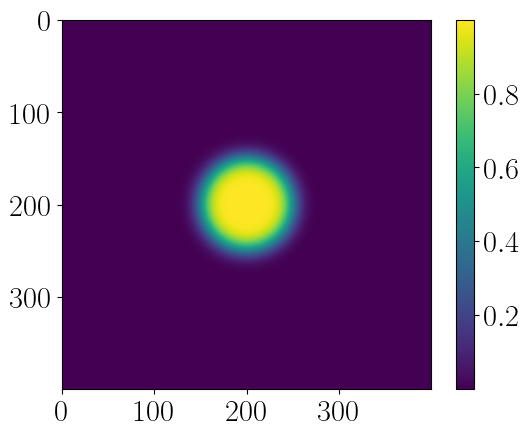

In [191]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

kappa = 1-rgb2gray(plt.imread('tmp_kappa.png'))
kappa = gaussian_filter(kappa, 10)
kappaFourier = baseMap.fourier(kappa)
plt.imshow(kappa)
plt.colorbar()

In [207]:
cmap = sns.cubehelix_palette(start=2.3, light=1, as_cmap=True, reverse=True)
cmap = 'bone'

Generate GRF unlensed CMB map (debeamed)


/tmp/ipykernel_1820595/3289646354.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tmp = -np.vstack((np.linspace(-1,0,num=400) for _ in range(400))).T


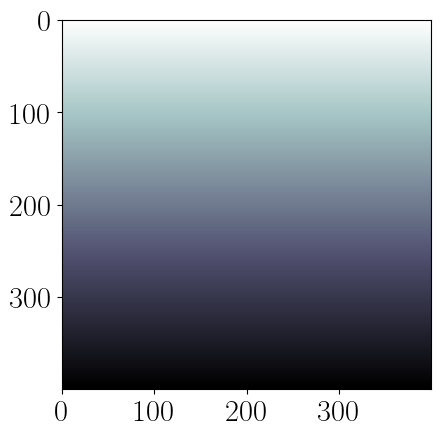

In [208]:
print("Generate GRF unlensed CMB map (debeamed)")

#generate GRF with the same power spectrum as the unlensed CMB
# cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
# cmb0 = baseMap.inverseFourier(cmb0Fourier)

tmp = -np.vstack((np.linspace(-1,0,num=400) for _ in range(400))).T
cmb0 = tmp
cmb0Fourier = baseMap.fourier(cmb0)

plt.imshow(cmb0, vmin=0, vmax=1, cmap=cmap)

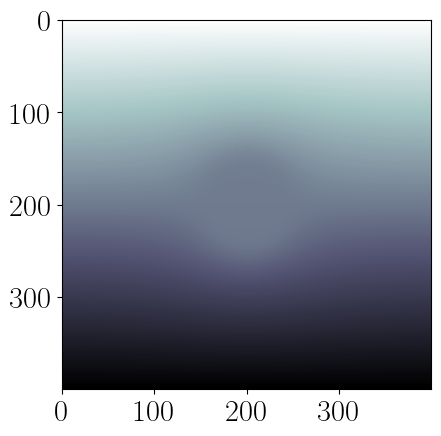

In [209]:
lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kappaFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)
plt.imshow(lensedCmb, vmin=0,vmax=1, cmap=cmap)